# Домашнее задание 1. Метод Монте-Карло
### Панкратов Никита

Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Задаем исходные данные (можно было бы и через np.array([]), но мне показалось для красоты и более лаконично будет использовать DataFrame)

In [14]:
rows = [[1000, 0.02, 0.007, 0, 0.2, 1], [2000, 0.01, 0.005, 0, 0.3, 1], [2500, 0.015, 0.01, 0, 0.4, 1]]
df = pd.DataFrame(rows, columns=['EAD', 'PD_mean', 'PD_sigma', 'LGD_min', 'LGD_mode', 'LGD_max'], index=['Loans A', 'Loans B', 'Loans C'])
df

,EAD,PD_mean,PD_sigma,LGD_min,LGD_mode,LGD_max
Loans A,1000,0.020,0.007,0,0.2,1
Loans B,2000,0.010,0.005,0,0.3,1
Loans C,2500,0.015,0.010,0,0.4,1


# 1 Вариант решения. Замена значений PD<0 на 0.

In [15]:
def lognormal(mean, std):
    #mu = ln(mean) - sigma^2/2
    sigma = np.sqrt(np.log(std**2 / (np.exp(1)**(2 * np.log(mean))) + 1))
    mu = np.log(mean) - sigma**2/2
    #mean = np.exp(1)**(mu + (sigma**2/2))
    #std = np.sqrt((np.exp(1)**sigma**2-1)*np.exp(1)**(2*mu + sigma**2))
    #print(mean, 'std= ', std)
    return np.random.lognormal(mu, sigma, size=1)

In [16]:
def pert(a, b, c, size=1, lamb=4):                                                           # ф-ия beta-PERT распределения (т. к. нам нужнно именно beta-pert распределение -> Лямбда=4)
    r = c - a
    alpha = 1 + lamb * (b - a) / r
    beta = 1 + lamb * (c - b) / r
    return a + np.random.beta(alpha, beta, size=size) * r

np.random.seed(42)                                                                           # seed выбран для наглядности в разнице ответов между двумя вариантами решений
EL = []
ans = []
count_neg_PD = 0
for i in range(50000):
    for j in range(len(df)):
        PD = lognormal(df.PD_mean[j], df.PD_sigma[j])
        if PD < 0:
            count_neg_PD += 1
        LGD = pert(df.LGD_min[j], df.LGD_mode[j], df.LGD_max[j]) 
        EL.extend(df.EAD[j] * PD * LGD)
    ans.append(sum(EL))
    #print(PD)
    EL = []
print('negative PD values: ', count_neg_PD)  #~4,5% (хвост короткий, но весит не совсем мало)

negative PD values:  0


Наши ожидаемые потери (подушка безопасности; 95% процентиль) =  58.38


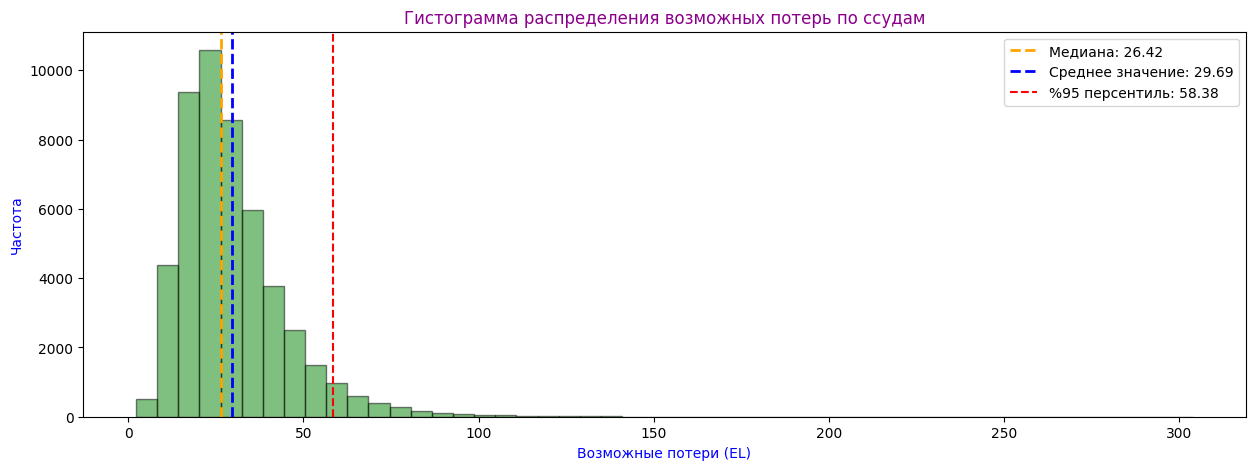

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.hist(ans, bins=50, color='green', alpha=0.5, edgecolor='black')

median_EAL = np.median(ans).round(2)                                                                 # считаем медиану
mean_EAL = np.mean(ans).round(2)                                                                     # считаем среднее
q_position_EAL = int(np.percentile(ans, 95)*100)/100.0                                               # считаем 95%-перцентиль

ax.axvline(median_EAL,color='orange',linewidth=2, linestyle='--',label=(f'Медиана: {median_EAL}'))
ax.axvline(mean_EAL,color='b',linewidth=2, linestyle='--',label=(f'Среднее значение: {mean_EAL}'))
ax.axvline(x=q_position_EAL, color='r', linestyle='--', label=(f'%95 персентиль: {q_position_EAL}'))

ax.set_title('Гистограмма распределения возможных потерь по ссудам', c='#8B008B')
ax.set_xlabel('Возможные потери (EL)', c='b')
ax.set_ylabel('Частота', c='b')
ax.legend()
print('Наши ожидаемые потери (подушка безопасности; 95% процентиль) = ', q_position_EAL)

In [18]:
def pert(a, b, c, size=1, lamb=4):                                                           # ф-ия beta-PERT распределения (т. к. нам нужнно именно beta-pert распределение -> Лямбда=4)
    r = c - a
    alpha = 1 + lamb * (b - a) / r
    beta = 1 + lamb * (c - b) / r
    return a + np.random.beta(alpha, beta, size=size) * r

np.random.seed(42)                                                                           # seed выбран для наглядности в разнице ответов между двумя вариантами решений
EL = []
ans = []
#count_neg_PD = 0
for i in range(50000):
    for j in range(len(df)):
        PD = np.log(np.random.lognormal(mean=df.PD_mean[j], sigma=df.PD_sigma[j], size=1))   # берем логаримф, так как нужны именно логарифмические зн-ия
        if PD < 0:                                                                           # так как вероятность не может быть отрицательной (по определению) -> меняем отрицательные значения на 0
            #count_neg_PD += 1
            PD = 0
        LGD = pert(df.LGD_min[j], df.LGD_mode[j], df.LGD_max[j]) 
        EL.extend(df.EAD[j] * PD * LGD)
    ans.append(sum(EL))
    EL = []
#print('negative PD values: ', count_neg_PD)  #~4,5% (хвост короткий, но весит не совсем мало)

### Визуализация

Наши ожидаемые потери (подушка безопасности; 95% процентиль) =  58.1


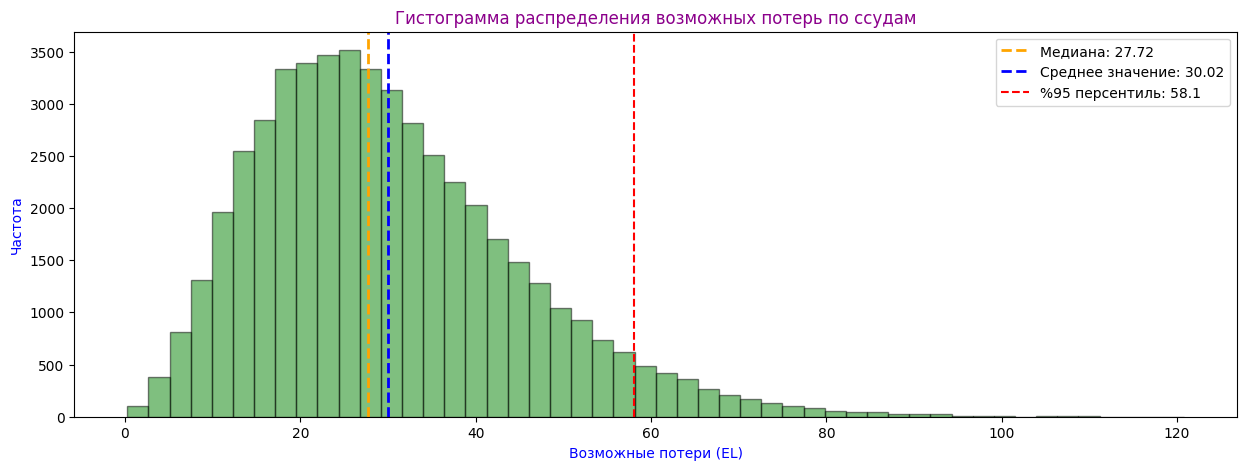

In [19]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.hist(ans, bins=50, color='green',alpha=0.5,edgecolor='black')

median_EAL = np.median(ans).round(2)                                                                 # считаем медиану
mean_EAL = np.mean(ans).round(2)                                                                     # считаем среднее
q_position_EAL = int(np.percentile(ans, 95)*100)/100.0                                               # считаем 95%-перцентиль

ax.axvline(median_EAL,color='orange',linewidth=2, linestyle='--',label=(f'Медиана: {median_EAL}'))
ax.axvline(mean_EAL,color='b',linewidth=2, linestyle='--',label=(f'Среднее значение: {mean_EAL}'))
ax.axvline(x=q_position_EAL, color='r', linestyle='--', label=(f'%95 персентиль: {q_position_EAL}'))

ax.set_title('Гистограмма распределения возможных потерь по ссудам', c='#8B008B')
ax.set_xlabel('Возможные потери (EL)', c='b')
ax.set_ylabel('Частота', c='b')
ax.legend()
print('Наши ожидаемые потери (подушка безопасности; 95% процентиль) = ', q_position_EAL)

# Вариант 2: перераспределение до тех пор, пока PD<0

In [20]:
EL = []
ans_2 = []
np.random.seed(42)
for i in range(50000):
    for j in range(len(df)):
        PD = np.log(np.random.lognormal(mean=df.PD_mean[j], sigma=df.PD_sigma[j], size=1))     # берем логаримф, так как нужны именно логарифмические зн-ия
        while PD < 0:                                                                          # будем моделировать по лог-нормальному распределению до тех пор, пока значение вероятности (PD) не будет >=0
            PD = np.log(np.random.lognormal(mean=df.PD_mean[j], sigma=df.PD_sigma[j], size=1))
        LGD = pert(df.LGD_min[j], df.LGD_mode[j], df.LGD_max[j]) 
        EL.extend(df.EAD[j] * PD * LGD)
    ans_2.append(sum(EL))
    EL = []


### Визуализация

Наши ожидаемые потери (подушка безопасности; 95% процентиль) =  58.65


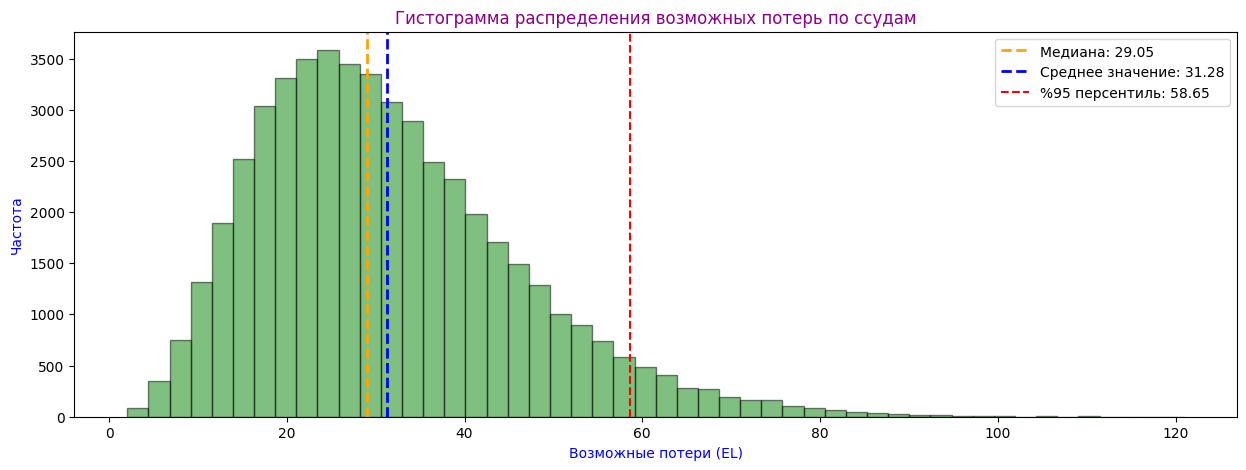

In [21]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.hist(ans_2, bins=50, color='green',alpha=0.5,edgecolor='black')

median_EAL_2 = np.median(ans_2).round(2)                                                                 # считаем медиану
mean_EAL_2 = np.mean(ans_2).round(2)                                                                     # считаем среднее
q_position_EAL_2 = int(np.percentile(ans_2, 95)*100)/100.0                                               # считаем 95%-перцентиль

ax.axvline(median_EAL_2, color='orange',linewidth=2, linestyle='--', label=(f'Медиана: {median_EAL_2}'))
ax.axvline(mean_EAL_2, color='b',linewidth=2, linestyle='--', label=(f'Среднее значение: {mean_EAL_2}'))
ax.axvline(x=q_position_EAL_2, color='r', linestyle='--', label=(f'%95 персентиль: {q_position_EAL_2}'))

ax.set_title('Гистограмма распределения возможных потерь по ссудам', c='#8B008B')
ax.set_xlabel('Возможные потери (EL)', c='b')
ax.set_ylabel('Частота', c='b')
ax.legend()
print('Наши ожидаемые потери (подушка безопасности; 95% процентиль) = ', q_position_EAL_2)